# Import Library

In [ ]:
import tensorflow as tf
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import re
from os import getcwd

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cwd = getcwd() + "/drive/Shareddrives/CAPSTONE_ML/"
print(cwd)

/content/drive/Shareddrives/CAPSTONE_ML/


In [ ]:
df_all = pd.read_excel(cwd + "df_all_new.xlsx")
df_all.head()

,Page_URL,Shop_name,Rating,Reviews,Kategori,Address,Phone_Number,Opening_Hours,Range_Harga,Latitude,Longitude,Eco_Friendly,Categorize_Weather
0,https://www.google.com/maps/place/Wedang+Uwuh+...,Wedang Uwuh Solo - Pak Aden,4.6,5,Wedang Uwuh,"Mutihan rt 04 rw 1, Surakarta, Sondakan, Kec. ...",082324006000,"{'Senin': ['08.00–20.00'], 'Selasa': ['08.00–2...",Rp 1–25 rb,-7.566731,110.716919,0,Dingin
1,https://www.google.com/maps/place/Rajanya+JAHE...,Rajanya JAHE REMPAH wedhang uwuh Sumber,4.6,32,Wedang Uwuh,"Jl. Letjen Suprapto No.76c, Sumber, Kec. Banja...",085641727445,"{'Minggu': ['Buka 24 jam'], 'Senin': ['Buka 24...",Rp 1–25 rb,-7.566731,110.716919,0,Dingin
2,https://www.google.com/maps/place/Wedang+uwuh+...,Wedang uwuh jelantik solo,5.0,1,Wedang Uwuh,"Jl. Sungai Musi No.1, Sangkrah, Kec. Ps. Kliwo...",081229070267,"{'Senin': ['Buka 24 jam'], 'Selasa': ['Buka 24...",Rp 1–25 rb,-7.576765,110.768229,0,Dingin
3,https://www.google.com/maps/place/Wedang+uwuh+...,Wedang uwuh mbok tuo,4.9,14,Wedang Uwuh,"Jl. Kutai Tim. 5B, RT.05/RW.08, Sumber, Kec. B...",081578614885,"{'Senin': ['07.00–19.00'], 'Selasa': ['07.00–1...",Rp 1–25 rb,-7.547894,110.730811,0,Dingin
4,https://www.google.com/maps/place/wedang+uwuh+...,wedang uwuh sya,4.7,3,Wedang Uwuh,"Jl. Reksoniten No.20, Gajahan, Kec. Ps. Kliwon...",089608149211,"{'Minggu': ['Buka 24 jam'], 'Senin': ['Buka 24...",Rp 1–25 rb,-7.547894,110.730811,0,Dingin


# Fungsi untuk menghitung jarak menggunakan formula haversine

In [ ]:
def calculate_haversine(lat1, lon1, lat2, lon2):
    earth_radius = 6371  # Radius bumi dalam kilometer
    delta_lat = np.radians(lat2 - lat1)
    delta_lon = np.radians(lon2 - lon1)
    a = np.sin(delta_lat / 2)**2 + np.cos(np.radians(lat1)) * np.cos(np.radians(lat2)) * np.sin(delta_lon / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    return earth_radius * c

# Inisialisasi lokasi pengguna

In [ ]:
# Lokasi pengguna
current_lat = -7.5589608
current_lon = 110.856106

# Menghitung jarak tiap lokasi berdasarkan input latitude dan longitude pengguna

In [ ]:
# Perhitungan jarak untuk setiap lokasi dalam dataset
df_all['computed_distance'] = df_all.apply(
    lambda row: calculate_haversine(current_lat, current_lon, row['Latitude'], row['Longitude']), axis=1
)

# Persiapan data untuk model


In [ ]:
# C = df_all['Rating'].mean()
# M = df_all['Reviews'].quantile(0.5)

# # Hitung Weighted Rating
# df_all['weighted_rating'] = ((df_all['Reviews'] / (df_all['Reviews'] + M)) * df_all['Rating']) + ((M / (df_all['Reviews'] + M)) * C)

# # Menyiapkan data fitur dan target
# features = df_all[['computed_distance', 'weighted_rating']]
# target = df_all['computed_distance']  # Target jarak untuk pemeringkatan

# # Normalisasi data fitur
# scaler = MinMaxScaler()
# features_normalized = scaler.fit_transform(features)

# # Membagi dataset menjadi training dan testing
# X_train, X_test, y_train, y_test = train_test_split(features_normalized, target, test_size=0.2, random_state=42)


# dataset = tf.data.Dataset.from_tensor_slices(dict(X_train), y_train)
# dataset = dataset.shuffle().batch(100)

In [ ]:
# Hitung Weighted Rating
C = df_all['Rating'].mean()
M = df_all['Reviews'].quantile(0.5)
df_all['weighted_rating'] = ((df_all['Reviews'] / (df_all['Reviews'] + M)) * df_all['Rating']) + ((M / (df_all['Reviews'] + M)) * C)

# Menyiapkan data fitur dan target
features = df_all[['computed_distance', 'weighted_rating']]
target = df_all['computed_distance']  # Target jarak untuk pemeringkatan

# Normalisasi data fitur
scaler = MinMaxScaler()
features_normalized = scaler.fit_transform(features)

# Membagi dataset menjadi training dan testing
X_train, X_test, y_train, y_test = train_test_split(features_normalized, target.to_numpy(), test_size=0.2, random_state=42)

# Pastikan bentuk data benar
print("X_train shape:", X_train.shape)  # (jumlah_data, jumlah_fitur)
print("y_train shape:", y_train.shape)  # (jumlah_data,)

# Buat dataset TensorFlow
dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))

# Opsional: Tambahkan shuffling dan batching
dataset = dataset.shuffle(buffer_size=100).batch(32)

X_train shape: (485, 2)
y_train shape: (485,)


# Membuat arsitektur model menggunakan adam optimizer dan loss Mean Squared Error dan menambahkan metrics mae (pengennya accuracy)

In [ ]:
# Membuat arsitektur model
model1 = tf.keras.Sequential([
    tf.keras.Input(shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(512, activation='relu'),
    #tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(256, activation='relu'),
    #tf.keras.layers.BatchNormalization(),
    #tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(128, activation='relu'),
    #tf.keras.layers.Dropout(0.1),
    # tf.keras.layers.Dense(64, activation='relu'),
    # tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(1)
])

# Kompilasi model
model1.compile(optimizer='adam', loss="mse", metrics=['mae'])  # Loss: Mean Squared Error, Metrics: Mean Absolute Error

# Memulai proses training dan menyimpannya kedalam variable history

In [ ]:
history = model1.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2)

Epoch 1/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - loss: 131.9282 - mape: 92.7368 - val_loss: 65.3734 - val_mape: 60.4855
Epoch 2/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 92.9878 - mape: 58.3894 - val_loss: 34.8721 - val_mape: 113.9265
Epoch 3/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 56.8081 - mape: 113.2898 - val_loss: 20.4639 - val_mape: 68.6967
Epoch 4/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 36.5279 - mape: 59.4164 - val_loss: 18.6730 - val_mape: 78.8837
Epoch 5/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 40.6426 - mape: 78.6001 - val_loss: 12.4135 - val_mape: 56.5008
Epoch 6/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 28.4177 - mape: 47.6337 - val_loss: 8.1586 - val_mape: 51.0852
Epoch 7/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 12.7273 - mape: 43.3206 - val_loss: 3.6513 - val_mape: 32.1222
Epoch 8/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 6.0353 - mape: 25.4418 - val_loss: 0.8197 - val_mape: 19.2697
Epoch 9/100
13

# Menguji performa model setelah dilakukan training

In [ ]:
test_loss, test_mae = model1.evaluate(X_test, y_test, verbose=0)
print(f"Mean Absolute Error pada data uji: {test_mae}")

Mean Absolute Error pada data uji: 0.1382572203874588


In [ ]:
# Membuat prediksi pada data baru
df_all['predicted_distance'] = model1.predict(features_normalized)

# Mendapatkan rekomendasi berdasarkan jarak terprediksi
top_recommendations = df_all.sort_values(by='predicted_distance', ascending=True).head(20)

# Menampilkan rekomendasi
print("Rekomendasi teratas berdasarkan prediksi jarak:")
print(top_recommendations[['Shop_name', 'Latitude', 'Longitude', 'Rating', 'Reviews', 'Categorize_Weather', 'computed_distance','predicted_distance']])


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Rekomendasi teratas berdasarkan prediksi jarak:
                                             Shop_name  Latitude   Longitude  \
453                    Sate Kambing Muda Kondang Laris -7.555006  110.858501   
273                                        SELAT LARAS -7.563668  110.853368   
50                                   Cafe Bukuku Lawas -7.560393  110.850782   
45                                       Kedai Bedjono -7.549122  110.857902   
287                                     Sop Kwali Solo -7.555214  110.844744   
59                                 Wedangan Mas Bonnie -7.571119  110.852502   
253                                         Omah Selat -7.566417  110.843382   
486                                Sate Babi Pak Ciwir -7.564732  110.841051   
176                            Warung Soto Daging Sapi -7.560530  110.838981   
478                                  Sate Babi Koh Gun -7.569508  110.842028   
262  Vien's Selat Cabang Rumah Sa

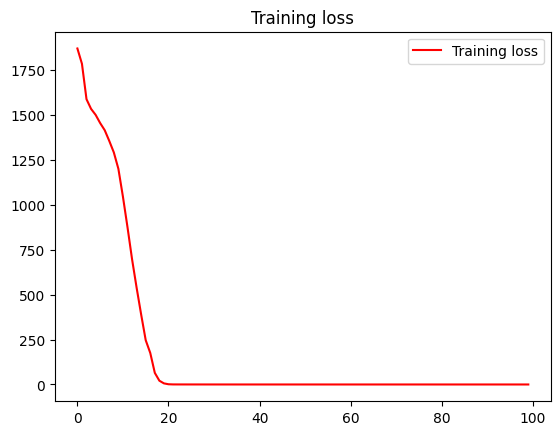

In [ ]:
# Plot training loss untuk tiap each
import matplotlib.pyplot as plt

loss = history.history['loss']

epochs = range(len(loss))

plt.plot(epochs, loss, 'r', label='Training loss')
plt.title('Training loss')
plt.legend(loc=0)
plt.show()

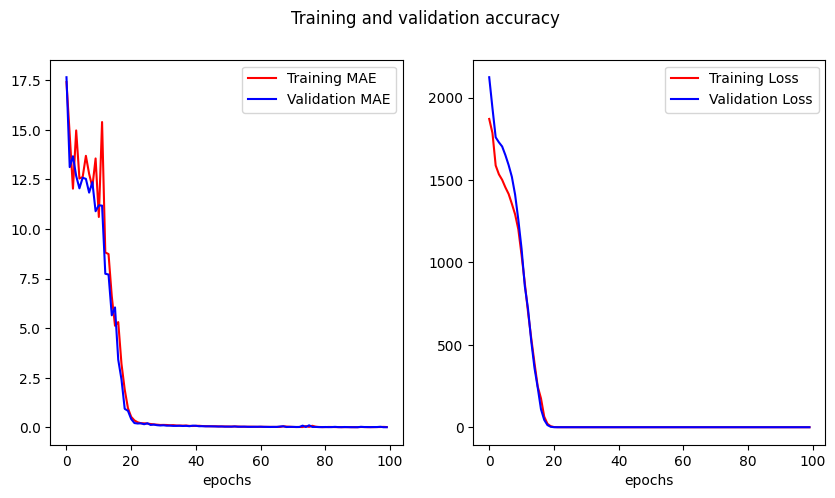

In [ ]:
# Akurasi training dan validasi
mae = history.history['mae']
val_mae = history.history['val_mae']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(mae))

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle('Training and validation accuracy')

for i, (data, label) in enumerate(zip([(mae, val_mae), (loss, val_loss)], ["MAE", "Loss"])):
    ax[i].plot(epochs, data[0], 'r', label="Training " + label)
    ax[i].plot(epochs, data[1], 'b', label="Validation " + label)
    ax[i].legend()
    ax[i].set_xlabel('epochs')

plt.show()